In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
from keras.utils import pad_sequences
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
tokenizer = text.Tokenizer()

In [3]:
corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k o k p",
    "h g y i u t a t e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]

In [4]:
tokenizer.fit_on_texts(corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}

In [5]:
corpus = [line.split(' ') for line in corpus]

In [6]:
wids = [[word2id[w] for w in sentence] for sentence in corpus]
vocab_size = len(word2id)

In [7]:
embed_size = 120
window_size = 2

In [8]:
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 31
Vocabulary Sample: [('9', 1), ('3', 2), ('o', 3), ('6', 4), ('a', 5), ('1', 6), ('g', 7), ('i', 8), ('4', 9), ('8', 10)]


In [ ]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

In [12]:
pairs, labels = skip_grams[0]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(3 (2), 2 (16)) -> 1
(8 (10), t (27)) -> 0
(2 (16), r (28)) -> 0
(6 (4), r (28)) -> 0
(4 (9), 6 (4)) -> 1
(6 (4), 8 (10)) -> 1
(2 (16), 3 (2)) -> 1
(3 (2), 0 (20)) -> 0
(2 (16), 5 (15)) -> 1
(5 (15), 8 (10)) -> 0


In [15]:
from keras.layers import Concatenate
from keras.layers.core import Dense, Reshape
from keras.models import Sequential

word_embeding = keras.layers.Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1)

# build skip-gram architecture
word_model = Sequential()
word_model.add()
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(keras.layers.Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
model.add(Concatenate([word_model, context_model]))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [11]:
context_length = window_size*2
# xs = []
# ys = []
# for pair in pairs:
#   xs.append(sequence.pad_sequences(pair[0], maxlen=context_length))
#   ys.append(tf.one_hot(pair[1], vocab_size))

dataset = [(tf.constant(pad_sequences(pair[0], maxlen=context_length)), tf.one_hot(pair[1], vocab_size))for pair in pairs]

2022-06-24 15:45:58.519581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
for x, y in dataset[:3]:
  print(x, y)

tf.Tensor([[ 0  0 16  9]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
tf.Tensor([[ 0 15  9 10]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)
tf.Tensor([[15 16 10  4]], shape=(1, 4), dtype=int32) tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]], shape=(1, 31), dtype=float32)


In [13]:
cbow = keras.Sequential([
  keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2, embeddings_initializer=keras.initializers.RandomNormal(0., 0.1)),
  keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(embed_size,)),
  keras.layers.Dense(vocab_size, activation='softmax')
])

cbow.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001))
cbow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 120)            3720      
                                                                 
 lambda (Lambda)             (None, 120)               0         
                                                                 
 dense (Dense)               (None, 31)                3751      
                                                                 
Total params: 7,471
Trainable params: 7,471
Non-trainable params: 0
_________________________________________________________________


In [14]:
for epoch in range(1, 1000):
    loss = 0.
    i = 0
    for x, y in dataset:
        i += 1
        loss += cbow.train_on_batch(x, y)
    if epoch % 20 == 0:
        print('Epoch:', epoch, '\tLoss:', loss)
        print()

Epoch: 20 	Loss: 302.48532205820084

Epoch: 40 	Loss: 221.86582326889038

Epoch: 60 	Loss: 186.37002000585198

Epoch: 80 	Loss: 166.39675444550812

Epoch: 100 	Loss: 153.21885147457942

Epoch: 120 	Loss: 143.58528498746455

Epoch: 140 	Loss: 136.12379736010917

Epoch: 160 	Loss: 130.15398201311473

Epoch: 180 	Loss: 125.27803441690048

Epoch: 200 	Loss: 121.22931917419191

Epoch: 220 	Loss: 117.82082676806021

Epoch: 240 	Loss: 114.9175876158115

Epoch: 260 	Loss: 112.41911237441673

Epoch: 280 	Loss: 110.24916667399884

Epoch: 300 	Loss: 108.34775884212104

Epoch: 320 	Loss: 106.66670225238522

Epoch: 340 	Loss: 105.16767906464338

Epoch: 360 	Loss: 103.82030128935867

Epoch: 380 	Loss: 102.60049261109543

Epoch: 400 	Loss: 101.48875834985324

Epoch: 420 	Loss: 100.46960073601917

Epoch: 440 	Loss: 99.53075327413649

Epoch: 460 	Loss: 98.66252077861952

Epoch: 480 	Loss: 97.85727083477849

Epoch: 500 	Loss: 97.10883633588716

Epoch: 520 	Loss: 96.41235200876574

Epoch: 540 	Loss: 95.7

In [17]:
for epoch in range(1001, 2000):
    loss = 0
    i = 0
    for x, y in dataset:
        i += 1
        loss += cbow.train_on_batch(x, y)
    if epoch % 10 == 0:
        print('Epoch:', epoch, '\tLoss:', loss)
        print()

Epoch: 1010 	Loss: 88.18087707098829

Epoch: 1020 	Loss: 88.14931708884347

Epoch: 1030 	Loss: 88.10234598151371

Epoch: 1040 	Loss: 88.05384246818932

Epoch: 1050 	Loss: 88.00588873442851

Epoch: 1060 	Loss: 87.9589421756796

Epoch: 1070 	Loss: 87.91310452071664

Epoch: 1080 	Loss: 87.86841381417602

Epoch: 1090 	Loss: 87.82466180643931

Epoch: 1100 	Loss: 87.78189395372922

Epoch: 1110 	Loss: 87.74002603468949

Epoch: 1120 	Loss: 87.69897871648575

Epoch: 1130 	Loss: 87.65876124312521

Epoch: 1140 	Loss: 87.61925145750328

Epoch: 1150 	Loss: 87.58049981526645

Epoch: 1160 	Loss: 87.54250308676345

Epoch: 1170 	Loss: 87.505211701445

Epoch: 1180 	Loss: 87.46861802343236

Epoch: 1190 	Loss: 87.43270952840513

Epoch: 1200 	Loss: 87.3973341859386

Epoch: 1210 	Loss: 87.36266270655406

Epoch: 1220 	Loss: 87.32856173004836

Epoch: 1230 	Loss: 87.29502002812788

Epoch: 1240 	Loss: 87.26192253412898

Epoch: 1250 	Loss: 87.22924642470699

Epoch: 1260 	Loss: 87.19699990798892

Epoch: 1270 	Los

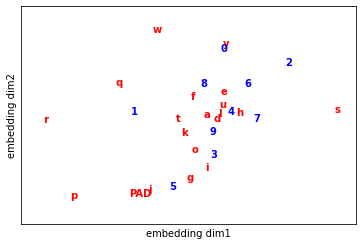

In [15]:
def show_w2v_word_embedding(model, path):
    word_emb = model.get_weights()[0]
    word_emb = word_emb[1:]
    for i in range(vocab_size -1):
        c = "blue"
        try:
            int(id2word[i])
        except ValueError:
            c = "red"
        plt.text(word_emb[i, 0], word_emb[i, 1], s=id2word[i], color=c, weight="bold")
    plt.xlim(word_emb[:, 0].min() - .5, word_emb[:, 0].max() + .5)
    plt.ylim(word_emb[:, 1].min() - .5, word_emb[:, 1].max() + .5)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("embedding dim1")
    plt.ylabel("embedding dim2")
    plt.savefig(path, dpi=300, format="png")
    plt.show()

show_w2v_word_embedding(cbow, './cbow.png')

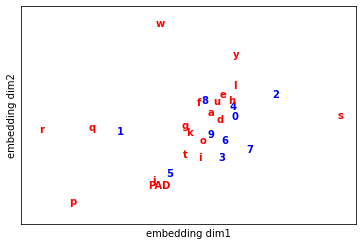

In [18]:
show_w2v_word_embedding(cbow, './cbow2.png')